<a href="https://colab.research.google.com/github/KoNozaki/quantmacro-hw/blob/main/%E5%AE%9A%E9%87%8F%E7%9A%84%E3%83%9E%E3%82%AF%E3%83%AD%E7%B5%8C%E6%B8%88%E5%AD%A6_%E6%9C%9F%E6%9C%AB%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 定量的マクロ経済学　期末課題

前半のように、新しく作ったgithubのリポジトリのリンク（前半とは別のリポジトリ！）を提出してください。そのリポジトリの中にpythonのコード(.ipynb)とそれぞれの問いに答えたpdfファイルを入れること。pdfファイルの中に図なども全て入れてください。（pdfファイルだけ読めばipynbファイルを見なくとも答えがわかるようにすること。）締切は7月24日23:59。
___________________________________________

近年所得格差が日本で問題になっている。格差是正のために色々な政策が考えられるが、その中でも(労働所得税ではなく)資本所得税を増加させ、国民全員に再分配する政策を実行すべきか
どうか考えたい。資本所得税は資本の利子所得raに比例する税金で、その税率をτkとする。そのために、日本のマクロ経済をコンピュータ上に表現し、以下の順番で政策実験を行う。この課題のためのgithubのリンクを新しく作って、その中に計算に使用したPythonコード(google colab)と 以下の問の答えを記述したpdfファイルを別々に用意し、そのリンクをCanvas経由で期限内に提出 すること。




#1
日本のマクロ経済を簡単に表現できる異質的な個人を含むモデルとその均衡の定義を記述せよ。

政府は上であげたような資本所得税を課税して、全員に同じだけ再分配している。

#2
τk = 0の時の定常状態均衡(総資本K、賃金w、利子率r)を計算せよ。

そして横軸を所得wh + ra、縦軸を各所得ごとの割合とした分布の図を描け。

さらに横軸を資産aとした同様の図も描くこと。

パラメータの値は講義中で共有したgoogle colabのノートブックで扱ったものとする。これが資本所得税導入前の日本経済となる。

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [173]:
# Tauchen法
def tauchen(n, mu, rho, sigma):
    # 入力：
      # n: グリッド点の数
      # mu: AR(1)過程の平均
      # rho: AR(1)の係数
      # sigma: 誤差項の標準偏差
    # 出力：
      # transition_matrix: n x n の遷移行列
      # state_space: n x 1 の状態空間の点のベクトル

    m = 1 / np.sqrt(1 - rho**2) # AR(1)過程の誤差項の標準偏差を計算

    # 状態空間を計算
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # グリッド間の距離を計算
    d = (state_space[n-1] - state_space[0]) / (n - 1)

    # 遷移確率を計算
    transition_matrix = np.zeros((n, n))
    for i in range(n): # 今日の状態
        for j in range(n): # 明日の状態
            if j == 0: # 下限への遷移確率
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # 上限への遷移確率
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # 下限
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # 上限
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low) # その他のグリッドポイントへの遷移確率

    return transition_matrix, state_space

In [174]:
# - setPar：パラメータの設定
def setPar(
    sigma = 1.50, # リスク回避度
    beta = 0.98, # 時間割引率
    delta = 0.03, # 減価償却率
    alpha = 0.25, # 資本の所得シェア
    rho = 0.6, # 労働生産性の持続性
    a_l = 0, # 資産グリッドの下限
    a_u = 20, # 資産グリッドの上限
    NH = 2, # hのグリッド数
    NA = 401, # aのグリッド数
    ):

    # 労働生産性の分散
    sigma_eps = np.sqrt(0.6*(1-rho**2))

    # hの対数に対するグリッドを作成し、tauchen法を用いて所得遷移確率を求める
    pi, h = tauchen(NH, -0.7, rho, sigma_eps)
    h = np.exp(h) # changing ln h grids to h grids

    # 所得遷移過程から定常分布を導出

    probst = np.ones((NH))/NH # 均一分布に対する初期推定値
    test = 10.0 # 距離を大きな値で初期化

    while test > 1e-8: # 定常分布が収束するまでループ
        probst_new = np.zeros((NH)) # 新しい分布を初期化
        for ih in range(NH): # 今日のh
            for ihp in range(NH): # 明日のh
                probst_new[ihp] += pi[ih, ihp]*probst[ih]

        test = np.max(np.abs(probst_new - probst)) # 推定値と新しい分布の差を計算
        probst = probst_new # 推定値を更新

    HH = np.sum(h*probst) # 総有効労働

	  # パラメータの辞書を作成
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH;

    return param

In [175]:
# - solve_household_gs：家計の最適化問題を解く
def solve_household_gs(param, r, w):

    # "param" の中のいくつかのパラメータを取り出す
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # 資産保有のグリッドを作成
    a = np.linspace(a_l, a_u, NA)

    # 消費がゼロまたは負の場合、効用関数を大きな負の数で初期化
    util = np.full((NA, NA, NH), -10000.0)

    # 各資産組み合わせ a[ia] と収入衝撃 h[ih] に対して、エージェントが資産 a[iap] を選択した場合の効用を計算
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # 消費が正の場合のみカウント
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # いくつかの変数を初期化
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # ベルマンの方程式を繰り返し計算し、最適な決定ルールと価値関数を取得
    test = 10
    while test != 0: # ポリシー関数が収束するまでループ
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # rewardの最大値を見つける
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # 最大値を見つける
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # 最大値のインデックスを見つける

        test = np.max(iaplus_new - iaplus) # iaplusが収束したら停止
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # 最適な消費
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

In [176]:
# - get_distribution：最適な貯蓄の決定に基づいた定常状態の分布を計算

def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # a_l と a_u の間に NA 個の等間隔の値を持つベクトルを生成
    a = np.linspace(a_l, a_u, NA)

    test = 10 # テスト値を 10^-8 より大きい値に初期化
    phi = np.ones((NA, NH)) / NA / NH # 分布 phi を一様分布に初期化

    # テスト値が 10^-8 未満になるまでループ
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # 新しい分布 phi_new を全てゼロで初期化
        # a, h, h' の全ての値についてループ
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # 補間のインデックス、ブレンディング係数、確率を用いて phi_new を更新
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi)) # phi_new と phi の最大差を計算
        phi = phi_new # phi を phi_new に更新

    return phi

In [177]:
# - model_solution：マクロ経済の定常状態を計算

def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # 更新割合
    toler = 1e-3 # 注意：許容誤差が小さすぎると収束しない
    test = 10 # 初期差
    KK = 10.0 # 初期資本

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # 企業の最適条件から資本の利子率と賃金を計算

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # 家計の最適化（資産の政策関数）を解く
        ####################################################

        decisions = solve_household_gs(param, r, w)

        aplus = decisions[0] # decisions の最初の要素（インデックス 0）を aplus と定義する

        ####################################################
        # 均衡分布と資本を求めるためのループ
        ####################################################

        # 均衡分布

        mu = get_distribution(param, decisions)

        # 新たな全体資本

        KK_new = np.sum(mu*aplus)

        ####################################################
        # 均衡資本を求めるためのループ
        ####################################################

        # メトリックを形成し、KK を更新

        test = abs((KK_new - KK)/KK) # Kが収束するまでループ
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # Kを更新

    return decisions, r, w, KK, HH, mu

In [178]:
# パラメータの設定
param = setPar()

# マクロ経済の定常状態を計算
(decisions, r, w, KK, HH, mu) = model_solution(param)

# decisions: 家計の最適な貯蓄と消費の決定
# r: 資本の利子率
# w: 労働賃金
# KK: 資本の定常状態の量
# HH: 労働の定常状態の量
# mu: 家計の資産と生産性ショックの定常状態の分布

ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
['0.0015', '8.0454', '8.0337']
['0.0023', '8.0431', '8.0614']
['0.0031', '8.0467', '8.0219']
['0.0024', '8.0418', '8.0614']
['0.0091', '8.0457', '7.9724']
['0.0117', '8.0310', '8.1249']
['0.0083', '8.0498', '7.9828']
['0.0039', '8.0364', '8.0676']
['0.0005', '8.0426', '8.0386']


In [179]:
# 総資本、賃金、利子率を表示
print(f"定常状態での総資本: {KK}")
print(f"定常状態での賃金: {w}")
print(f"定常状態での利子率: {r}")

定常状態での総資本: 8.041822600504139
定常状態での賃金: 1.3033754232108015
定常状態での利子率: 0.017633798605864934


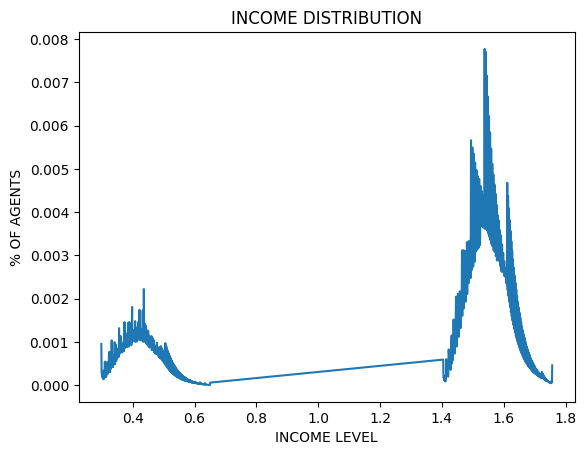

In [180]:
# 所得分布を計算しプロット
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

h = param['h'] # 労働生産性を取得

# 各グリッドに対する所得分布を計算
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])]) # 所得は資本の収益と労働収入の和
# 所得の配列を転置
income = income.T
# 所得をフラット化しソート
pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
plambda = mu.flatten('F')[index] # 各所得レベルに対応するエージェントの割合を計算

# 所得分布をプロット
plt.figure()
plt.plot(pinc, plambda)
plt.title('INCOME DISTRIBUTION')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

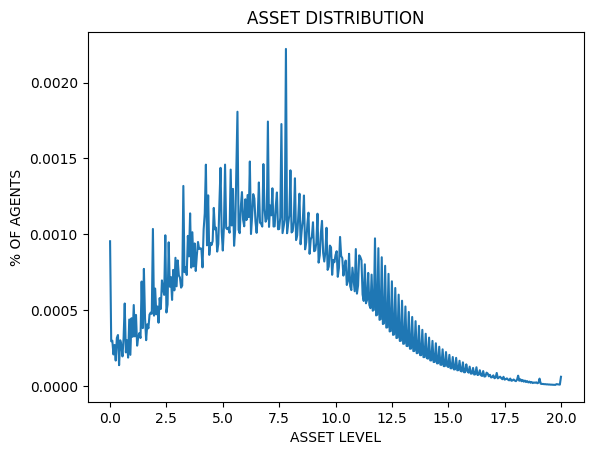

In [181]:
# 資産分布を計算しプロット
zip_lists = zip(a.flatten('F'), mu.flatten('F'))
zip_sort = sorted(zip_lists)
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title('ASSET DISTRIBUTION')
plt.xlabel('ASSET LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

#3

上のモデルを使い、資本所得税率τkを0%から5%に増加させる実験をする。その増加分は 全国民(家計)に全員同じ決まった額だけもらえる形で再分配する。ただし、政府の予算制約は毎期必ず均衡しなくてはいけない。

このモデルにおいて定常状態均衡を計算し、

上の問題のように所得と資産の分布の図を描け。

このモデルに基づくと資本所得税を増加させると日本経済の所得格差はどう変化するか? 数値で答えること。

GDPは何%変化するか?

あなたが政策担当者ならば資本所得税は増加させるか?その理由は?

In [182]:
# - solve_household_gs_2：家計の最適化問題を解く
def solve_household_gs_2(param, r, w, tau_k, T):

    # パラメータを取り出す
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # 資産のグリッドを作成
    a = np.linspace(a_l, a_u, NA)

    # 消費がゼロまたは負の場合の効用関数を大きな負の数で初期化
    util = np.full((NA, NA, NH), -10000.0)

    # エージェントが資産a[iap]を選択した場合の各資産組み合わせa[ia]と収入衝撃h[ih]に対する効用を計算
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap] - tau_k*r*a[ia] + T
                if cons > 0: # 消費が正の場合のみ効用を計算
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # いくつかの変数を初期化
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # ベルマンの方程式を繰り返し計算し、最適な決定ルールと価値関数を取得
    test = 10
    while test != 0: # ポリシー関数が収束するまでループ
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # rewardの最大値を見つける
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # 最大値を見つける
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # 最大値のインデックスを見つける

        test = np.max(iaplus_new - iaplus) # iaplusが収束したら停止
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # 最適な消費
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r*(1-tau_k))*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

In [183]:
# - model_solution_2：マクロ経済の定常状態を計算
def model_solution_2(param, tau_k, T):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # 更新率
    toler = 1e-3 # 許容誤差。小さすぎると収束しない。
    test = 10 # 初期差
    KK = 10.0 # 初期資本

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # 企業の最適条件から資本の利子率と賃金を計算

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # 家計の最適化を解く
        ####################################################

        decisions = solve_household_gs_2(param, r, w, tau_k, T)

        aplus = decisions[0] # decisions の最初の要素（インデックス 0）を aplus と定義する

        ####################################################
        # 均衡分布と資本を求めるためのループ
        ####################################################

        # 均衡分布

        mu = get_distribution(param, decisions)

        # 新しい総資本

        KK_new = np.sum(mu*aplus)

        ####################################################
        # 均衡資本を求めるためのループ
        ####################################################

        # メトリックを形成し、KK を更新

        test = abs((KK_new - KK)/KK) # Kが収束するまでループ
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # Kを更新

    return decisions, r, w, KK, HH, mu

In [184]:
# 新しい税率 tau_k で定常状態を再計算
tau_k = 0.05
param['tau_k'] = tau_k

#この部分がわかりませんでした
#本来はnp.sum(a[:, np.newaxis] * mu) ではなくKKを使いたいです
T = tau_k * r * np.sum(a[:, np.newaxis] * mu)

(decisions, r, w, KK, HH, mu) = model_solution_2(param, tau_k, T)

# 総資本、賃金、利子率を表示
print(f"定常状態での総資本: {KK}")
print(f"定常状態での賃金: {w}")
print(f"定常状態での利子率: {r}")

ITERATING ON KK

  metric    Kold      Knew
['0.5666', '10.0000', '4.3338']
['0.4077', '8.8668', '5.2521']
['0.1813', '8.1438', '6.6672']
['0.0065', '7.8485', '7.8994']
['0.0009', '7.8587', '7.8657']
定常状態での総資本: 7.86009844152837
定常状態での賃金: 1.295858401500011
定常状態での利子率: 0.01846755955196966


資本所得税の導入により総資本が初期状態の10から7.8657に減少したと言える

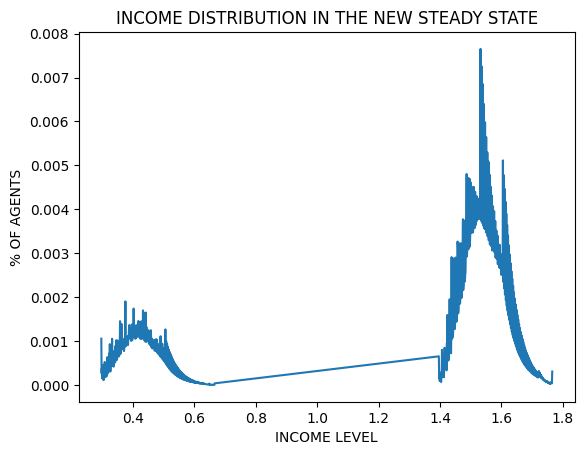

In [185]:
# 新しい定常状態での所得分布を計算しプロット
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

h = param['h'] # 労働生産性を取得

# 新しい定常状態の各グリッドでの所得分布を計算
income_new = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# incomeを転置
income_new = income_new.T
# "income_new"をフラット化（1次元配列化）した後でソート
pinc_new, index_new = np.sort(income_new.flatten('F')), np.argsort(income_new.flatten('F'))
plambda_new = mu.flatten('F')[index_new]

# 新しい定常状態での所得分布をプロット
plt.figure()
plt.plot(pinc_new, plambda_new)
plt.title('INCOME DISTRIBUTION IN THE NEW STEADY STATE')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

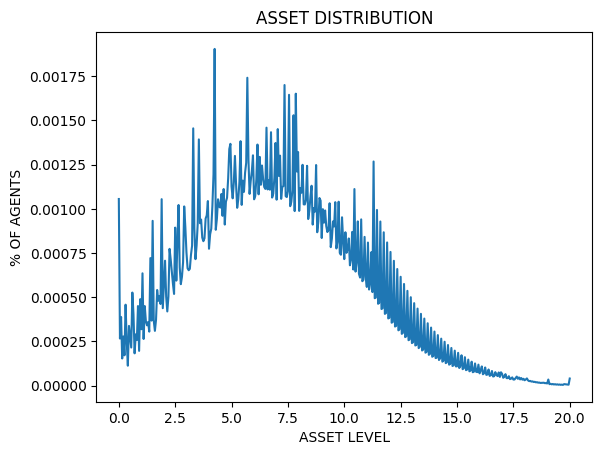

In [186]:
# 所得分布を計算しプロット
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# 資産分布を計算しプロット
zip_lists = zip(a.flatten('F'), mu.flatten('F'))
zip_sort = sorted(zip_lists)
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title('ASSET DISTRIBUTION')
plt.xlabel('ASSET LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

In [187]:
#所得格差をジニ係数で表す
# ジニ係数を計算する関数
def gini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()  # 平均絶対差
    rmad = mad/np.mean(x)  # 相対的な平均絶対差
    return 0.5 * rmad  # ジニ係数

# 各グリッドでの所得分布を計算
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
income = income.T

# 所得をフラット化（1次元配列化）し、ジニ係数を計算
income_flat = income.flatten('F')
gini_before = gini(income_flat)

# 新しい税率tau_kで定常状態を再計算
tau_k = 0.05
param['tau_k'] = tau_k
T = tau_k * r * np.sum(a[:, np.newaxis] * mu)
(decisions, r, w, KK, HH, mu) = model_solution_2(param, tau_k, T)

# 各グリッドでの所得分布を再計算
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
income = income.T

# 所得をフラット化し、ジニ係数を再計算
income_flat = income.flatten('F')
gini_after = gini(income_flat)

# 所得格差の変化を計算し表示
change_in_inequality = gini_after - gini_before
print("Change in income inequality: ", change_in_inequality)

ITERATING ON KK

  metric    Kold      Knew
['0.5666', '10.0000', '4.3338']
['0.4077', '8.8668', '5.2521']
['0.1851', '8.1438', '6.6365']
['0.0075', '7.8424', '7.9016']
['0.0048', '7.8542', '7.8162']
['0.0070', '7.8466', '7.9015']
['0.0012', '7.8576', '7.8666']
['0.0011', '7.8594', '7.8511']
['0.0002', '7.8577', '7.8563']
Change in income inequality:  -6.268935834885525e-06


ジニ係数の変化は約-0.00000627となった。

したがって、資本所得税率を 0% から 5% に増加させると、所得格差が微小ながらも減少すると言える。

In [188]:
#GDPの変化
# 総税収を計算
tau_k = 0.05
param['tau_k'] = tau_k
T = tau_k * r * np.sum(a[:, np.newaxis] * mu)
# 新しい税率を考慮した新しい定常状態を求める
(decisions_new, r_new, w_new, KK_new, HH_new, mu_new) = model_solution_2(param, tau_k, T)

# 税率変更前のGDPを計算
Y_before = KK**(param['alpha']) * HH**(1-param['alpha'])

# 税率変更後のGDPを計算
Y_after = KK_new**(param['alpha']) * HH_new**(1-param['alpha'])

# GDPのパーセンテージ変化を計算
GDP_change = ((Y_after - Y_before) / Y_before) * 100
GDP_change
print("Change in GDP: ", change_in_inequality)

ITERATING ON KK

  metric    Kold      Knew
['0.5666', '10.0000', '4.3338']
['0.4077', '8.8668', '5.2521']
['0.1851', '8.1438', '6.6365']
['0.0075', '7.8424', '7.9016']
['0.0048', '7.8542', '7.8162']
['0.0070', '7.8466', '7.9015']
['0.0047', '7.8576', '7.8948']
['0.0051', '7.8650', '7.8247']
['0.0001', '7.8570', '7.8563']
Change in GDP:  -6.268935834885525e-06


GDPは約-0.002%減少した。

したがって、資本所得税率を 0% から 5% に増加させると、GDPが微小ながらも減少すると言える。

このモデルの結果をもとに考えると、資本所得税の増税は所得格差とGDPをどちらも縮小させるという結果になった。